In [82]:
import os 
import numpy as np
from util import plot_figure
import matplotlib
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import seaborn as sns
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
color_list = sns.color_palette()
from util import compute_spectral_gap

### Check Details

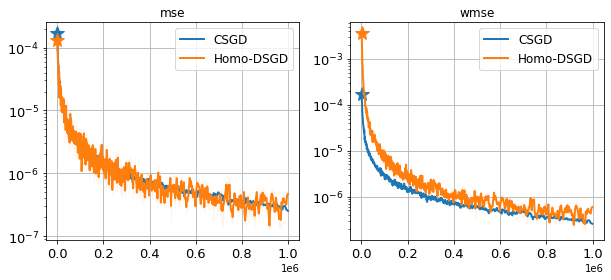

In [83]:
num_agent = 40
# 20, 30, 40, 50
fig, ax = plt.subplots(1, 2, figsize=(5*2, 4))

def subplot(me, ax, fig_idx ):

    plot_csgd = plot_figure(algo_name=f'csgd', sub_sample=1, dir=f'./s2_res/NumAgent{num_agent}/', log_flag=False, metric='mse')
    plot_csgd.plot_lines(ax[fig_idx], color_list[0], label='CSGD', legend=True, plot_star=True)

    plot_dsgd_homo = plot_figure(algo_name=f'dsgd-homo', sub_sample=1, dir=f'./s2_res/NumAgent{num_agent}/', log_flag=False, metric=me)
    plot_dsgd_homo.plot_lines(ax[fig_idx], color_list[1], label='Homo-DSGD', legend=True, plot_star=True,)

    if num_agent <= 20:
        plot_dsgd_hete = plot_figure(algo_name=f'dsgd-hete', sub_sample=1, dir=f'./s2_res/NumAgent{num_agent}/', log_flag=False, metric=me)
        plot_dsgd_hete.plot_lines(ax[fig_idx], color_list[2], label='Hete-DSGD', legend=True, plot_star=True,)
    ax[fig_idx].grid(True)
    ax[fig_idx].set_title(f'{me}')

subplot('mse',  ax=ax, fig_idx=0)
subplot('wmse', ax=ax, fig_idx=1)

plt.grid(True)

## Compute Transient time

In [84]:
def load_data(dir, word):
    file = [f for f in os.listdir(dir) if word in f]
    files = [np.load(os.path.join(dir, f), allow_pickle=True) for f in file]
    res = np.array([f.item().get('wmse') for f in files])
    xvals = files[0].item().get('iter')
    mean_res = np.mean(res, axis=0)
    return xvals, mean_res

def find_window(data, window_size, threshold):
    start_index = 0
    while start_index + window_size <= len(data):
        window = data[start_index:start_index+window_size]
        count = np.sum(window < threshold)
        if count >= window_size :
            return start_index + window_size - 1
        start_index += 1
    return None


num_agent_list = [5, 10, 15, 18, 20, 23, 25, 26, 28, 29, 30, 31, 32, 33, 
                34, 35, 37, 38, 39, 40,]
xvals = []
tran_time_list = []
tran_time_list_hete = []
graph = 'RingGraph' #StarGraph'
window_size = 3

for num_agent in num_agent_list:
    # Get sqrt(n)/rho
    file_name = f's2_mixMat/' + f'MixingMat-{graph}-NumAgent{num_agent}.npy'
    W = np.load(file_name)
    spectral_gap = compute_spectral_gap(W)
    if spectral_gap.imag == 0:
        spectral_gap = spectral_gap.real
    
    xvals.append(np.sqrt(num_agent)/spectral_gap)
    # xvals.append(np.sqrt(num_agent))

    # Get tran time
    parent_path = f'./s2_res/NumAgent{num_agent}'
    x_csgd, y_csgd = load_data(parent_path, 'csgd')
    keyword_dsgd = f'dsgd-homo-{graph}'
    _, y_dsgd = load_data(parent_path, keyword_dsgd)

    ratio = y_dsgd / y_csgd
    index = find_window(ratio, window_size, 4)
    if index is None:
        raise ValueError(f'Num Agent:{num_agent} No transient time found')
    tran_time = x_csgd[index]
    tran_time_list.append(tran_time)

    ## get transient time for hete
    if num_agent < 20:
        keyword_dsgd = f'dsgd-hete-{graph}'
        _, y_dsgd = load_data(parent_path, keyword_dsgd)

        ratio = y_dsgd / y_csgd
        index = find_window(ratio, window_size, 2)
        if index is None:
            # raise ValueError(f'Num Agent:{num_agent} No transient time found')
            tran_time_list_hete.append(None)
        else:
            tran_time = x_csgd[index]
            tran_time_list_hete.append(tran_time)
    else:
        tran_time_list_hete.append(None)

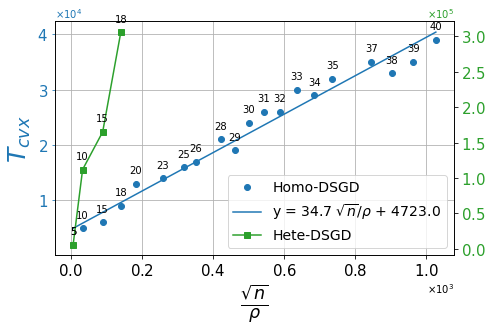

In [87]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

# Create figure and axis
fig, ax = plt.subplots(figsize=(7.15, 4.3))  # 设置图片大小为 7.15x4.3

# 第一条线
coefficients = np.polyfit(xvals, tran_time_list, 1)
linear_fit = np.poly1d(coefficients)
homo_marker = ax.plot(xvals, tran_time_list, 'o', color=color_list[0], markersize=6, label='Homo-DSGD')
fit_line = ax.plot(xvals, linear_fit(xvals), '-', 
                    label=f'y = {coefficients[0]:.1f} $\\sqrt{{n}}/\\rho$ + {coefficients[1]:.1f}', 
                    color=color_list[0])

# x轴与y轴使用科学计数法
ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))

# 标注点上的数值
for i, (x, y) in enumerate(zip(xvals, tran_time_list)):
    ax.annotate(f'{num_agent_list[i]}', (x, y), textcoords="offset points", xytext=(0, 10), ha='center')

# 设置坐标轴和刻度大小
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15, colors=color_list[0])
ax.set_xlabel(r'$\frac{\sqrt{n}}{\rho}$', fontsize=25)
ax.set_ylabel(r'$T_{cvx}$', fontsize=25, color=color_list[0])

# 第二条线 (右边y轴)
ax2 = ax.twinx()
hete_line = ax2.plot(xvals, tran_time_list_hete, label=r'Hete-DSGD', color=color_list[2], marker='s', markersize=6, linestyle='-')
ax2.tick_params(axis='y', labelsize=15, labelcolor=color_list[2])

# 第二条线右边的y轴使用科学计数法
ax2.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax2.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))

# 为右边的y轴标注点上的数值
for i, (x, y) in enumerate(zip(xvals, tran_time_list_hete)):
    if y is not None:
        ax2.annotate(f'{num_agent_list[i]}', (x, y), textcoords="offset points", xytext=(0, 10), ha='center')

# 添加图例
ax.grid(True)

lines, labels = ax.get_legend_handles_labels() 
lines2, labels2 = ax2.get_legend_handles_labels()

plt.legend(lines + lines2, labels + labels2, loc='lower right', prop={'size': 14})

# 保存图片
plt.savefig('./fig/s1_tran.pdf', bbox_inches='tight')
plt.show()